# Feature Selection_1 

* [Processing DATE feature](#chapter1)
* [Dropping CELL_Type columns](#chapter2)
* [Drop SITE_ID feature](#chapter3)
* [Feature importances](#chapter4)
* [All features vs 14days ones](#chapter5)
* [t-testing precision and recall](#chapter6)

In [5]:
import pandas as pd
import seaborn as sns
import os
import sys
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import cross_validate


from sklearn.model_selection import StratifiedKFold


from scipy import stats


sys.path.append('..')


We use an helper file called helper.py which contains support functions to process the original dataframe

In [6]:
from helper import data_container

In [7]:
dataset_path = '../dataset/train.csv'
#testset_path = '../dataset/test.csv'

In [8]:
df = pd.read_csv(dataset_path)
#test = pd.read_csv(testset_path)

In [9]:
#container = data_container(dataset)
#prepared_dataset = container.prepared_dataset

## Processing DATE feature <a class="anchor" id="chapter1"></a>

We process the DATE feature and extract 3 extra features and we drop the original DATE feature column: 
1. Day -> encoded in sine-cosine for cyclic values. 30 is near to 1 and 29
2. Month
3. Year

In [10]:
# process data feature
df['DATE'] = pd.to_datetime(df['DATE'])
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['year'] = df['DATE'].dt.year % 2019
df['day' + '_sin'] = np.sin(2 * np.pi * df['day'] / df['day'].max())
df['day' + '_cos'] = np.cos(2 * np.pi * df['day'] / df['day'].max())
df = df.drop(columns='day')
df = df.drop(columns='DATE')
df

,SITE_ID,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_TRP,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,...,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,month,year,day_sin,day_cos
0,146,1,0,0,0,0,3.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,8.978045e-01,-0.440394
1,146,1,0,0,0,0,3.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,7.907757e-01,-0.612106
2,146,1,0,0,0,0,3.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,6.513725e-01,-0.758758
3,146,1,0,0,0,0,3.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,4.853020e-01,-0.874347
4,146,1,0,0,0,0,3.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,2.993631e-01,-0.954139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621295,1251,1,0,0,0,0,7.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,1,1,-2.012985e-01,0.979530
621296,1251,1,0,0,0,0,7.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,1,1,-2.449294e-16,1.000000
621297,1251,1,0,0,0,0,7.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,2,1,2.012985e-01,0.979530
621298,1251,1,0,0,0,0,7.0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,2,1,3.943559e-01,0.918958


## Dropping CELL_Type columns <a class="anchor" id="chapter2"></a>

We drop the columns related to the cell types. Classes are heavy unbalanced and CELL_TPR has no instances in our dataset.

In [11]:
temp = df[['SITE_ID','CELL_TYPE_Macro', 'CELL_TYPE_Mobil', 'CELL_TYPE_TRP', 'CELL_TYPE_Tx site', 'CELL_TYPE_micro']]
IDs = (temp.groupby('SITE_ID').sum())/300
IDs = IDs.astype(int)

In [12]:
#number of elements per class
values = IDs.sum()
values

CELL_TYPE_Macro      1909
CELL_TYPE_Mobil         2
CELL_TYPE_TRP           0
CELL_TYPE_Tx site      69
CELL_TYPE_micro        76
dtype: int64

[Text(0, 0, 'CELL_TYPE_Macro'),
 Text(1, 0, 'CELL_TYPE_Mobil'),
 Text(2, 0, 'CELL_TYPE_TRP'),
 Text(3, 0, 'CELL_TYPE_Tx site'),
 Text(4, 0, 'CELL_TYPE_micro')]

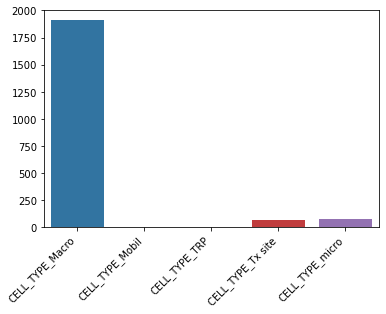

In [13]:
ax = sns.barplot(x = values.index, y = values)
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right')

In [14]:
cell_type = [col for col in df.columns if 'CELL_TYPE' in col]
df = df.drop(columns=cell_type)
df

,SITE_ID,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,...,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,month,year,day_sin,day_cos
0,146,3.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,8.978045e-01,-0.440394
1,146,3.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,7.907757e-01,-0.612106
2,146,3.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,6.513725e-01,-0.758758
3,146,3.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,4.853020e-01,-0.874347
4,146,3.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,2.993631e-01,-0.954139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621295,1251,7.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,1,1,-2.012985e-01,0.979530
621296,1251,7.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,1,1,-2.449294e-16,1.000000
621297,1251,7.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,2,1,2.012985e-01,0.979530
621298,1251,7.0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,2,1,3.943559e-01,0.918958


## Drop SITE_ID feature <a class="anchor" id="chapter3"></a>
**SITE_IDs** between training set and test set are different, thus having the **SITE_ID** in the training set is not meaningful. We want to predict the fault probability based on "general" features such as alarms, weather ecc... we don't want to be site dependent. 

In [15]:
df = df.drop(columns='SITE_ID')
df

,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,...,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,month,year,day_sin,day_cos
0,3.0,0,0,0,0,0,0,0,0,1,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,8.978045e-01,-0.440394
1,3.0,0,0,0,0,0,0,0,0,1,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,7.907757e-01,-0.612106
2,3.0,0,0,0,0,0,0,0,0,1,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,6.513725e-01,-0.758758
3,3.0,0,0,0,0,0,0,0,0,1,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,4.853020e-01,-0.874347
4,3.0,0,0,0,0,0,0,0,0,1,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,4,0,2.993631e-01,-0.954139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621295,7.0,0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,1,1,-2.012985e-01,0.979530
621296,7.0,0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,1,1,-2.449294e-16,1.000000
621297,7.0,0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,2,1,2.012985e-01,0.979530
621298,7.0,0,0,0,0,0,0,0,0,0,...,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,2,1,3.943559e-01,0.918958


## Feature importances <a class="anchor" id="chapter4"></a>

We use different tree based algorithms to check which features are the most important.

In [16]:
X = df.drop(columns=['aircon_sum_target_next14d'])
y = df['aircon_sum_target_next14d']

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0, stratify = y)

In [18]:
#support function to plot features importance barplot. std and non std versions

def plot_feature_importance(importance,names,model_type, std):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance, 'std_feature': std}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], xerr=fi_df['std_feature'] )
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [19]:
#support function to plot features importance barplot

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [20]:
# Random Forest
clf_RandomForest = RandomForestClassifier(n_estimators = 50,random_state=0, n_jobs = 2)
clf_RandomForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0)

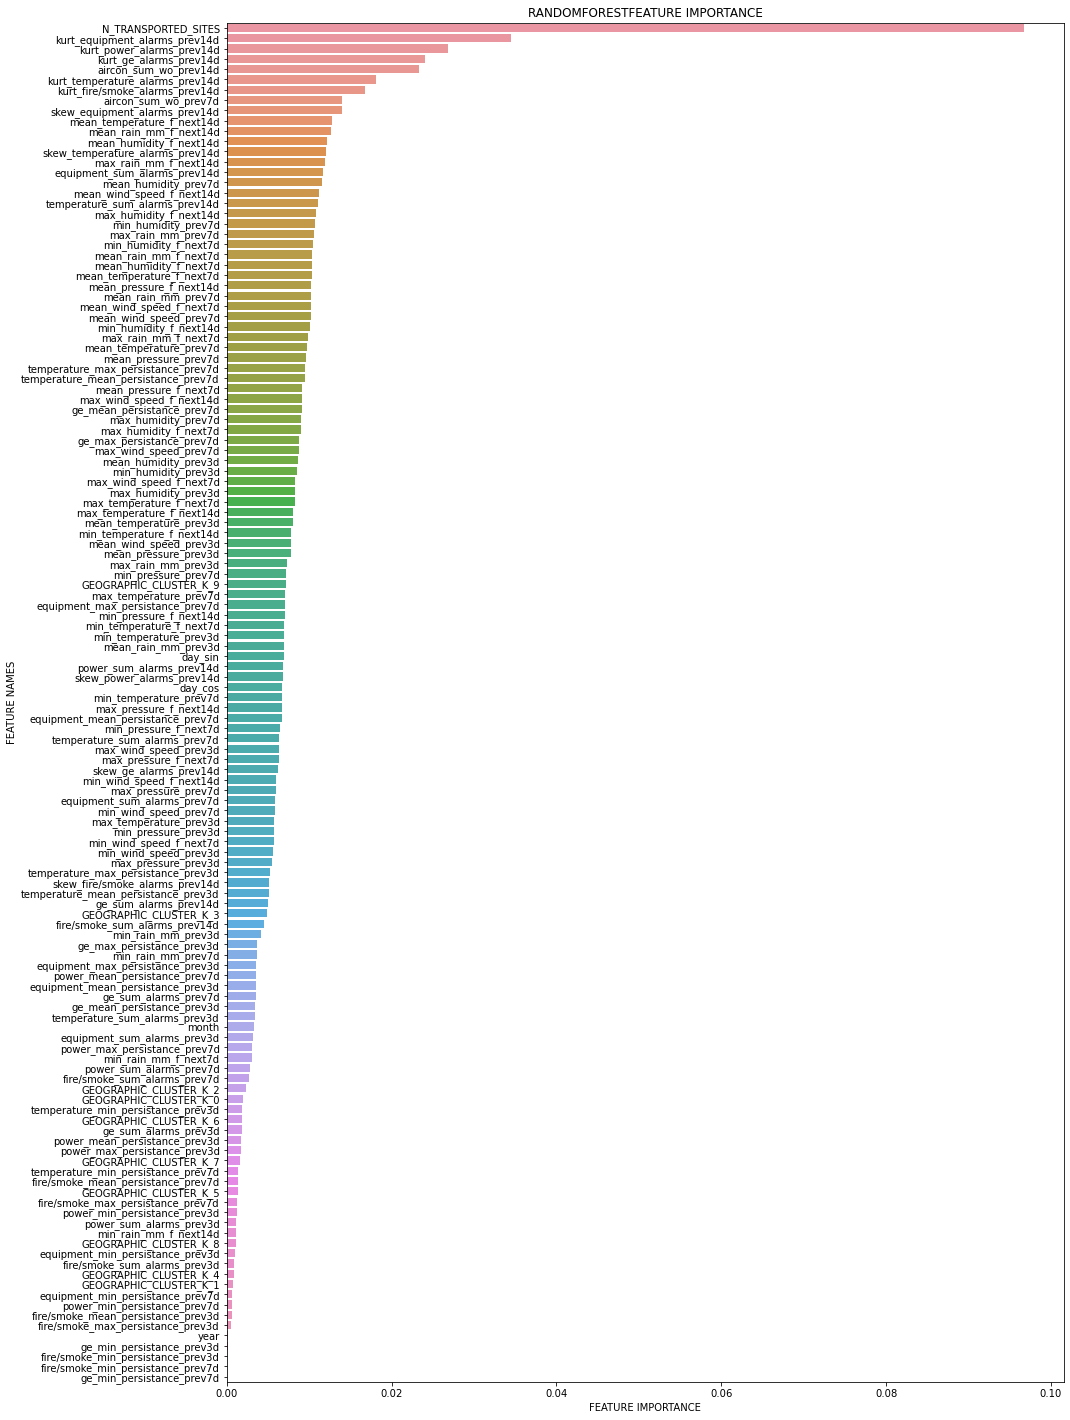

In [22]:
plot_feature_importance(clf_RandomForest.feature_importances_,X.columns, 'RANDOMFOREST')

In [23]:
# X randomized trees
clf_ExtraTrees = ExtraTreesClassifier(n_estimators=50, random_state=0, n_jobs = 2)
clf_ExtraTrees.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=50, n_jobs=2, random_state=0)

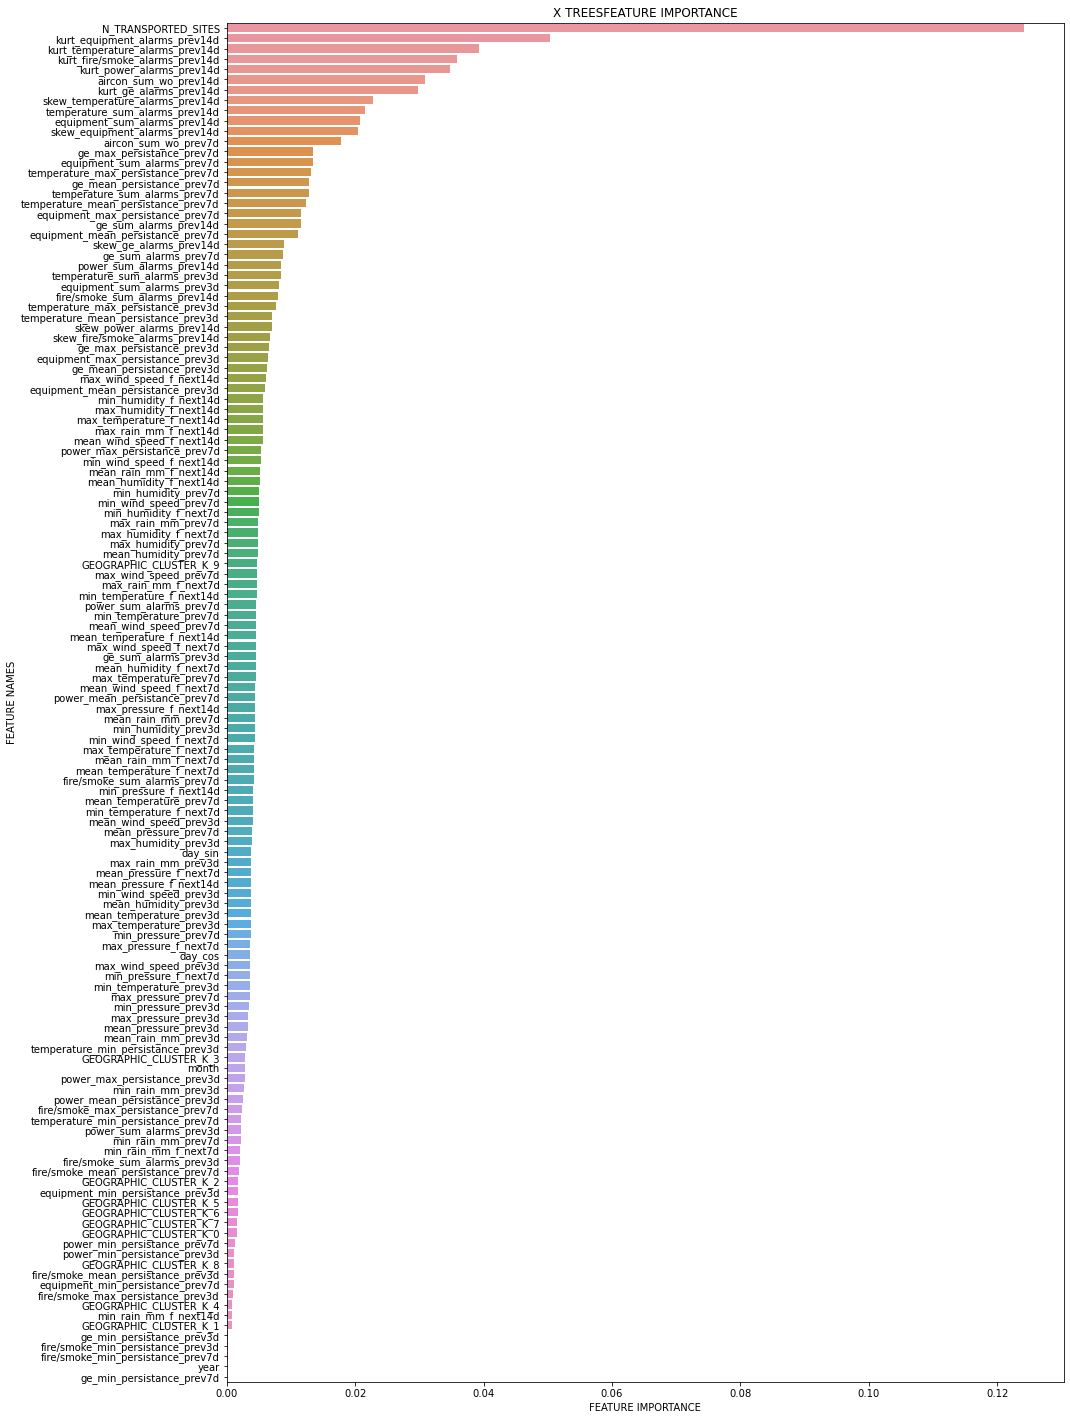

In [25]:
plot_feature_importance(clf_ExtraTrees.feature_importances_,X.columns, 'X TREES')

In [26]:
clf_AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=0)
clf_AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   random_state=0)

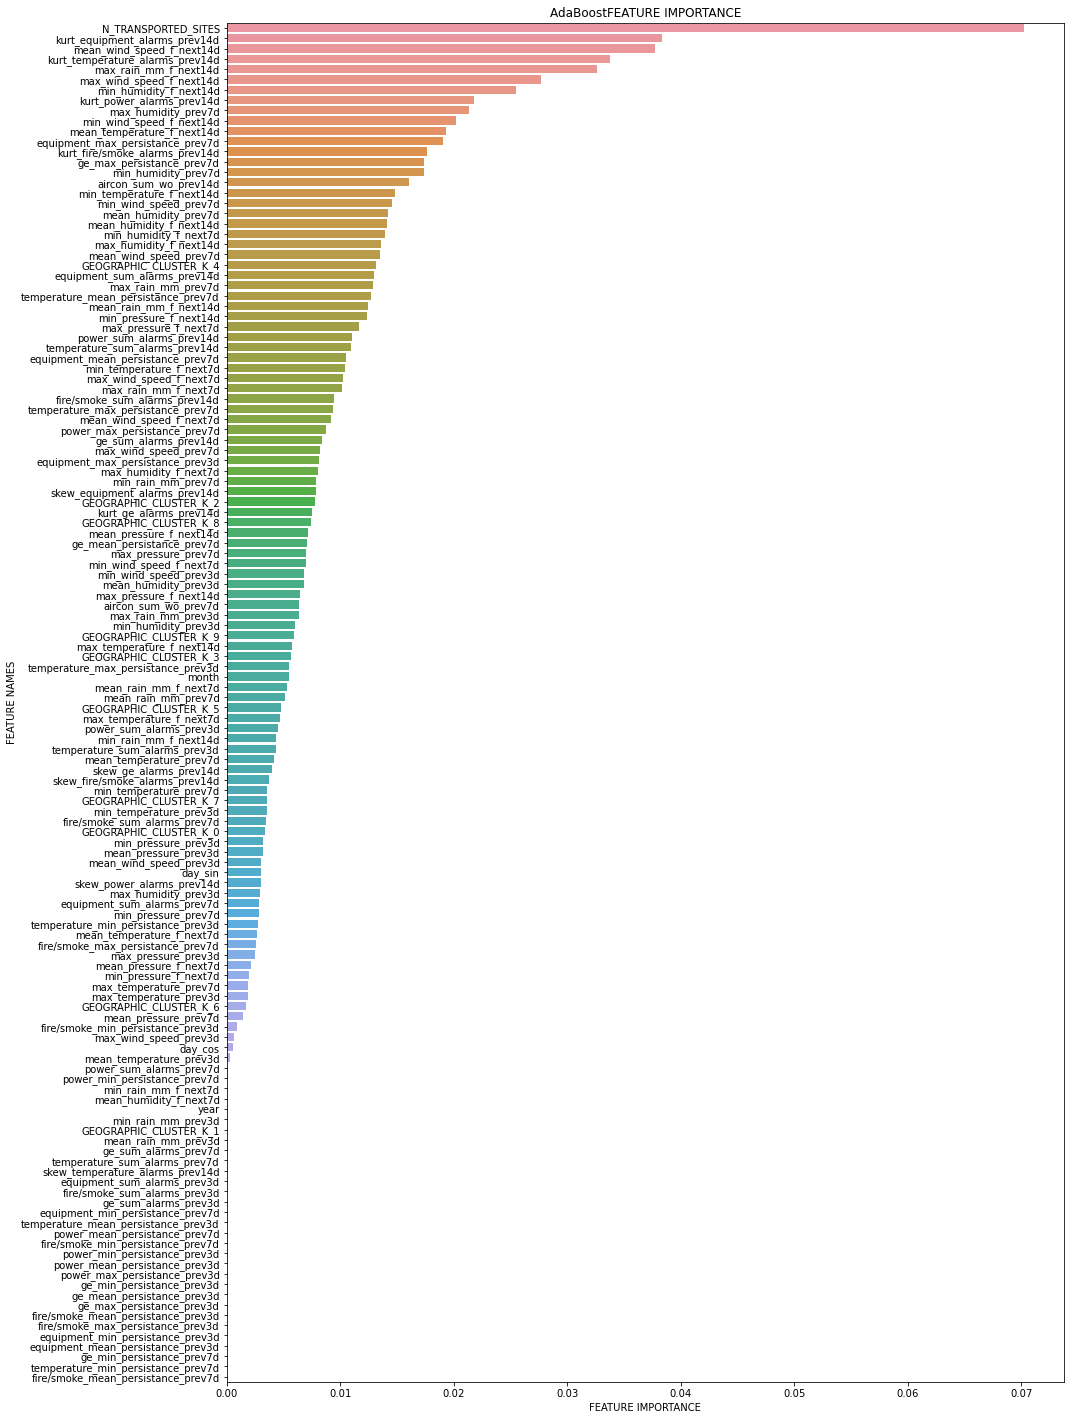

In [28]:
plot_feature_importance(clf_AdaBoost.feature_importances_,X.columns, 'AdaBoost')

We noticed that all the tree based algorithms prefer the longer time frame features: if we take the same feature, the one with the longer time frame has more importance for our model. We thought this could be meaningful since our target variable has a time frame of 14 days, thus we decided to analyze if  matching time frame features are better. 

## All features vs 14days ones <a class="anchor" id="chapter5"></a>

We compute all the features on a 14 days time frame. We extract the 14 day time frame using two consequent 7 days frame. We end up with a dataframe containing all the features computed on 14 days. 

In [29]:
dataset = pd.read_csv(dataset_path)

#using helper function to get already processed data as mentioned above
container = data_container(dataset)

In [30]:
#helper function, returns a dataframe with only 14 days features.
df_14 = container.compute_14d_features()
pd.set_option('display.max_columns', None)

df_14

,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_f_next14d,max_temperature_f_next14d,min_temperature_f_next14d,mean_rain_mm_f_next14d,max_rain_mm_f_next14d,min_rain_mm_f_next14d,mean_humidity_f_next14d,max_humidity_f_next14d,min_humidity_f_next14d,mean_wind_speed_f_next14d,max_wind_speed_f_next14d,min_wind_speed_f_next14d,mean_pressure_f_next14d,max_pressure_f_next14d,min_pressure_f_next14d,equipment_sum_alarms_prev14d,fire/smoke_sum_alarms_prev14d,ge_sum_alarms_prev14d,power_sum_alarms_prev14d,temperature_sum_alarms_prev14d,skew_equipment_alarms_prev14d,skew_fire/smoke_alarms_prev14d,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,max_temperature_prev14d,min_temperature_prev14d,mean_temperature_prev14d,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day_sin,day_cos
0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.00,12.0,5.0,4.79,19.6,0.1,74.29,89.0,58.0,12.86,17.0,5.0,1020.71,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,14.0,6.0,10.290,8.5,0.0,1.330,81.0,45.0,62.710,16.0,5.0,11.430,1022.0,1006.0,1013.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8.978045e-01,-0.440394
1,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.50,16.0,5.0,3.52,12.5,0.1,72.93,89.0,58.0,12.57,17.0,5.0,1021.71,1028.0,1013.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.710,8.5,0.0,1.900,81.0,51.0,66.430,16.0,5.0,11.570,1017.0,1006.0,1010.860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,7.907757e-01,-0.612106
2,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,9.36,20.0,5.0,3.63,12.5,0.1,72.00,89.0,58.0,12.29,17.0,5.0,1022.14,1028.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.570,19.6,0.0,4.700,88.0,58.0,71.710,16.0,5.0,11.710,1015.0,1006.0,1009.710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,6.513725e-01,-0.758758
3,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,10.57,22.0,5.0,3.40,12.5,0.1,70.07,89.0,58.0,12.14,17.0,5.0,1021.86,1028.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,8.0,11.290,19.6,0.0,4.770,88.0,58.0,74.290,16.0,5.0,11.430,1013.0,1006.0,1009.430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4.853020e-01,-0.874347
4,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,11.50,22.0,5.0,3.49,12.5,0.1,69.07,89.0,58.0,11.64,17.0,5.0,1021.29,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,5.0,10.570,19.6,0.3,5.390,88.0,58.0,77.290,15.0,5.0,10.860,1016.0,1006.0,1009.860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2.993631e-01,-0.954139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [31]:
X = df.drop(columns=['aircon_sum_target_next14d'])
y = df['aircon_sum_target_next14d']

X_14 = df_14.drop(columns=['aircon_sum_target_next14d'])
y_14 = df_14['aircon_sum_target_next14d']

In [32]:
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [33]:
#https://scikit-learn.org/stable/modules/model_evaluation.html
scoring = ['precision', 'recall']
clf_RandomForest = RandomForestClassifier(n_estimators = 50, random_state=0)
scores = cross_validate(clf_RandomForest, X, y, scoring=scoring, cv=crossvalidation, verbose = 2, n_jobs= 2)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 10.6min finished


In [34]:
#https://scikit-learn.org/stable/modules/model_evaluation.html
scoring_14 = ['precision', 'recall']
clf_RandomForest_14 = RandomForestClassifier(n_estimators = 50, random_state=0)
scores_14 = cross_validate(clf_RandomForest_14, X_14, y_14, scoring=scoring_14, cv=crossvalidation, verbose = 2, n_jobs = 2)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  8.0min finished


In [35]:
scores

{'fit_time': array([221.55186725, 222.94099975, 227.26581383, 223.07303786,
        174.80420899]),
 'score_time': array([2.57912731, 2.47055984, 2.62328529, 2.8260231 , 2.55001283]),
 'test_precision': array([0.78703704, 0.72020725, 0.73096447, 0.73972603, 0.77981651]),
 'test_recall': array([0.23743017, 0.19413408, 0.20083682, 0.22594142, 0.23709902])}

In [36]:
scores_14

{'fit_time': array([137.5245676 , 137.30629325, 185.29248381, 176.69860077,
        155.38457584]),
 'score_time': array([2.46560478, 2.39866114, 3.49743915, 3.69301939, 2.37591529]),
 'test_precision': array([0.88451444, 0.85585586, 0.85      , 0.86246418, 0.88034188]),
 'test_recall': array([0.47067039, 0.39804469, 0.42677824, 0.41980474, 0.43096234])}

## t-testing precision and recall. <a class="anchor" id="chapter6"></a>
We apply a t-test comparing the two models to find if we have statistically significance in the above reported improvements using 14_days features. The t-test is statistically significant for both precision and recall

In [37]:
#check if we need bonferroni correction

confidence_level = 0.99
paired_test = stats.ttest_rel(scores['test_recall'], scores_14['test_recall'])
print(paired_test)

if (paired_test[1]<(1-confidence_level)):
    print('statistically significant')


Ttest_relResult(statistic=-25.56169241720048, pvalue=1.3911522245419283e-05)
statistically significant


In [38]:
confidence_level = 0.99
paired_test = stats.ttest_rel(scores['test_precision'], scores_14['test_precision'])
print(paired_test)

if (paired_test[1]<(1-confidence_level)):
    print('statistically significant')


Ttest_relResult(statistic=-16.122636470056253, pvalue=8.65665208236224e-05)
statistically significant
